In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import arviz as az

In [2]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0true = np.zeros(n_x)
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

In [3]:
# Observation Parameters
sigma_n_true = 0.005
spatial_points = 10
temporal_points = 10

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

In [4]:
true_alpha = 1
true_beta = 1

@fem.BilinearForm
def a(u,v,w):
    x = w.x
    return u*v

@fem.BilinearForm
def b(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

@fem.LinearForm
def l(v,w):
    x = w.x
    f = 8 * np.cos(np.pi*8*x[0]) + true_beta
    return (f)*v
    #return (0.)*v

A_mat = a.assemble(basis)
B_mat = b.assemble(basis)
L_vec = l.assemble(basis)

def boundary_function(boundary_coordinate_list):
    return 0.

pre_OP1 = A_mat + dt*B_mat
pre_OP1[boundary_indices, :] = pre_OP1[:, boundary_indices] = 0.
pre_OP1[boundary_indices, boundary_indices] = 1.
OP1 = scsparse.linalg.inv(pre_OP1)

for i, t in enumerate(time_range[:-1]):
    OP2 = dt*L_vec + A_mat @ u_strue[i,:]
    OP2[boundary_indices] = boundary_function(true_coordinates[boundary_indices])
    #u_s[i,boundary_indices] = boundary_function(coordinates[boundary_indices])
    #u_s[i+1,:] = dt*OP1 @ L_vec + OP1 @ A_mat @ u_s[i,:]
    u_strue[i+1,:] = OP1 @ OP2

u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


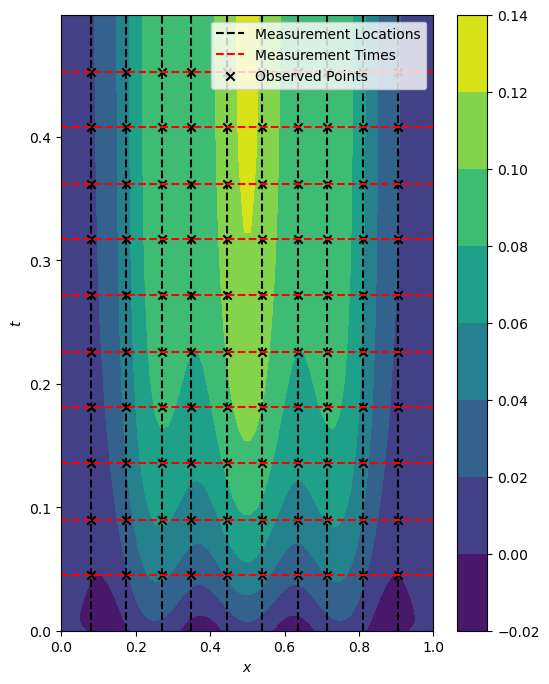

In [5]:
fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', label='Measurement Times', color='red')
    else:
        axes.axhline(coord, linestyle='--', color='red')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.scatter(x_temp, y_temp, marker='x', label='Observed Points', color='black')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()

In [6]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0 = np.zeros(n_x)
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

covs = []

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [7]:
@fem.BilinearForm
def M_form(u,v,w):
    return u*v

@fem.BilinearForm
def A_form(u,v,w):
    return dot(grad(u),grad(v))

@fem.LinearForm
def L_form(v,w):
    return 1. * v

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

A_mat = (A_form.assemble(basis)).toarray()
L_vec = L_form.assemble(basis)
M_mat = (M_form.assemble(basis)).toarray()

def left_side(alpha):
    left_mat = (M_mat + (dt*alpha/2)*A_mat)
    # left_mat = subtensor.set_subtensor(left_mat[0,:], 0.)
    # left_mat = subtensor.set_subtensor(left_mat[-1,:], 0.)
    # left_mat = subtensor.set_subtensor(left_mat[0,0], 1.)
    # left_mat = subtensor.set_subtensor(left_mat[-1,-1], 1.)
    left_mat[boundary_indices,:] = left_mat[:,boundary_indices] = 0.
    left_mat[boundary_indices, boundary_indices] = 1.
    return left_mat

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    return tensor.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))


In [8]:
# PRIORS ------------
# alpha
lower = 0.0001
upper = 3.
mu = 1.
sigma = 0.5
alpha_params = [lower, upper, mu, sigma]

# beta
lower = 0.0001
upper = 3.
mu = 1.
sigma = 0.5
beta_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.1
sigma = 0.01
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 0.1
sigma = 0.1
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 1.
mu = 0.005
sigma = 0.005
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [9]:

# alpha = 1.
# beta = 1.
# rho = 0.1
# ell = 0.1
# sigma_n = 0.005

alpha = alpha_params[2]
beta = beta_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

# left_hand_side = (M_mat + (dt*alpha/2)*A_mat)
# left_hand_side[boundary_indices,:] = left_hand_side[:,boundary_indices] = 0.
# left_hand_side[boundary_indices, boundary_indices] = 1.
inv_left_hand = np.linalg.inv(left_side(alpha))
G_mat = G_theta_mat_np(rho, ell)



data_index = 0
for i, t in tqdm(enumerate(time_range[:-1])):
    if i == 0:
        right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
        right_hand_side[0] = right_hand_side[-1] = 0.
        pred_mean = inv_left_hand @ right_hand_side
        pred_cov = dt*inv_left_hand @ M_mat @ G_mat @ M_mat.T @ inv_left_hand.T
        u_s[i+1, :] = pred_mean
        covs.append(pred_cov)
    else:
        if time_operator[i] == False:
            right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
            right_hand_side[0] = right_hand_side[-1] = 0.
            pred_mean = inv_left_hand @ right_hand_side
            u_s[i+1,:] = pred_mean
            covs.append(covs[-1])
        else:
            #with pm.Model() as model:
                # alpha = pm.TruncatedNormal('alpha', mu=alpha_params[3], sigma=alpha_params[2], lower=alpha_params[0], upper=alpha_params[1])
                # beta = pm.TruncatedNormal('beta', mu=beta_params[3], sigma=beta_params[2], lower=beta_params[0], upper=beta_params[1])
                # rho = pm.TruncatedNormal('rho', mu=rho_params[3], sigma=rho_params[2], lower=rho_params[0], upper=rho_params[1])
                # ell = pm.TruncatedNormal('ell', mu=ell_params[3], sigma=ell_params[2], lower=ell_params[0], upper=ell_params[1])
                # sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[3], sigma=sigma_n_params[2], lower=sigma_n_params[0], upper=sigma_n_params[1])
                
                # left_side_matrix = pm.Deterministic('left_side', left_side(alpha))
                # G_rho_ell = pm.Deterministic('G_rho_ell', M_mat @ G_theta_mat(rho, ell) @ M_mat.T)

                # left_side_inv = tensor.nlinalg.matrix_inverse(left_side_matrix)

                # mu_u = pm.Deterministic('mu_u', A_alpha_inv @ L_beta)
                # cov_u = pm.Deterministic('cov_u', A_alpha_inv @ G_rho_ell @ A_alpha_inv.T)

                # cov_chol = tensor.linalg.cholesky(current_observation_set[2] @ cov_u @ current_observation_set[2].T + sigma_n**2 * np.eye(len(current_observation_set[1])))
                # y_obs = pm.MvNormal('y_obs', mu = current_observation_set[2] @ mu_u, chol = cov_chol, observed=current_observation_set[1])
                # #trace = pm.sample(draws=300, tune=300)
                # #trace = pm.sample(target_accept=0.9)
                # #trace = pm.sample(nuts_sampler="numpyro", chains=4, target_accept=0.95)
                # trace = pm.sampling.jax.sample_numpyro_nuts(chains=2, chain_method='parallel', target_accept=0.95)
                
            pred_cov = (inv_left_hand @ (M_mat - (dt*alpha/2)*A_mat)) @ covs[-1] @ (inv_left_hand @ (M_mat - (dt*alpha/2)*A_mat)).T + dt*inv_left_hand @ M_mat @ G_mat @ M_mat.T @ inv_left_hand.T
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ np.linalg.inv(observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)) @ (u_observed[data_index] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ np.linalg.inv(observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)) @ observation_operator @ pred_cov
            u_s[i+1,:] = updated_mean
            covs.append(updated_cov)
            data_index += 1


cov_diags = np.zeros((number_of_steps, number_of_x_axial_cells))
for i in range(number_of_steps-1):
    cov_diags[i,:] = np.diag(covs[i])

499it [00:00, 41793.12it/s]


In [10]:
temporal_measurement_indices

array([ 45,  90, 136, 181, 226, 272, 317, 362, 408, 453])

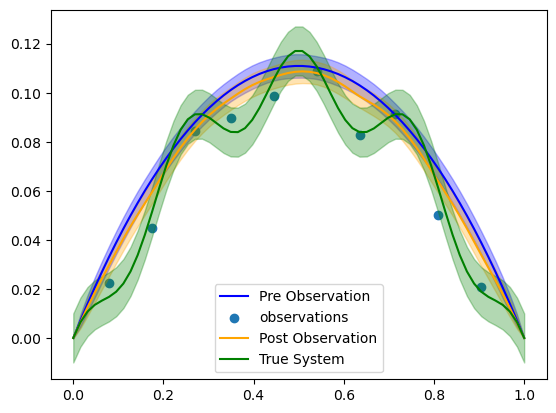

In [15]:
interest = 5
plot_ind = temporal_measurement_indices[interest]
plt.plot(coordinates,u_s[plot_ind,:], label='Pre Observation', color='blue')
plt.fill_between(coordinates.flatten(), u_s[plot_ind,:] - 2*np.sqrt(cov_diags[plot_ind]), u_s[plot_ind,:] + 2*np.sqrt(cov_diags[plot_ind]), alpha=0.3, color='blue')
plt.scatter(spatial_measurement_coordinates, u_observed[interest,:], label='observations')
plt.plot(coordinates,u_s[plot_ind + 1,:], label='Post Observation',color='orange')
plt.fill_between(coordinates.flatten(), u_s[plot_ind+1,:] - 2*np.sqrt(cov_diags[plot_ind+1]), u_s[plot_ind+1,:] + 2*np.sqrt(cov_diags[plot_ind+1]), alpha=0.3, color='orange')
plt.plot(true_coordinates, u_strue[plot_ind+1,:], label='True System', color='green')
plt.fill_between(true_coordinates.flatten(), u_strue[plot_ind+1,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[plot_ind+1,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), color='green', alpha=0.3)
plt.legend()

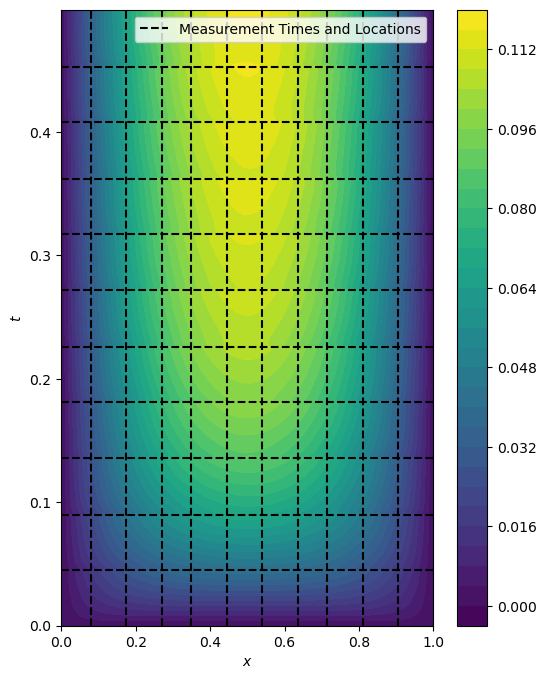

In [12]:
fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(coordinates.flatten(), time_range, u_s, levels=30)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()

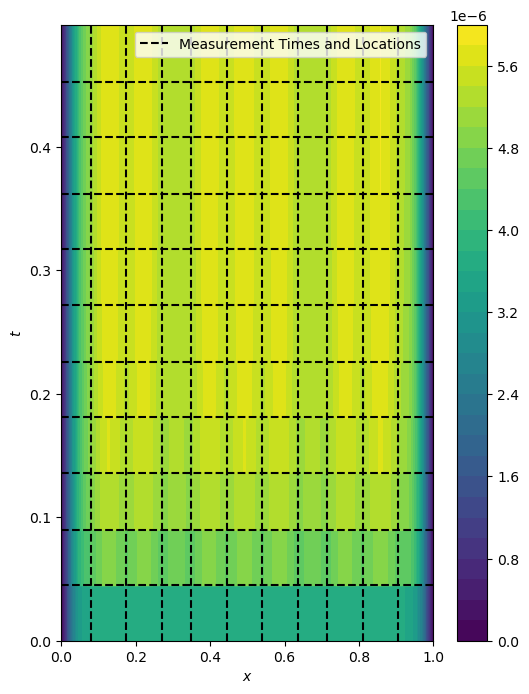

In [13]:
fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(coordinates.flatten(), time_range, cov_diags, levels=30)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()